In [66]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import GPy
from scipy.optimize import minimize

**Gaussian Process Implementation**

We first define the function to approximate:

$$f(x_1,x_2) = 100  (x_2-x_1^2)^2 + (1-x_1)^2$$

In [3]:
def f(x):
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

bounds = np.array([[-2.5,2.5],[-2.5,2.5]]) # defining bounds for the function 

A Gaussian process is implemented as follows using the GPy library:

In [52]:
n = 100 # datapoints
d = len(bounds) # dimension of function 
# generating random data points without bounds
b_range = bounds[:,1] - bounds[:,0]
X  = (np.random.uniform(0,1,(n,d))*b_range)+bounds[:,0] 

$X \in \mathbb{R}^{n \times d}$ where $n$ is the number of datapoints and $d$ is the dimension of the function.

In [53]:
Y = np.array([[f(xi)] for xi in X])

Y are evaluations of the modelled function, note Y is a column vector e.g. $Y\in \mathbb{R}^{n \times 1}$.

In [69]:
kernel = GPy.kern.RBF(input_dim=d,ARD=True); # define the kernel function
# see https://gpy.readthedocs.io/en/deploy/GPy.kern.html for more kernel functions
m = GPy.models.GPRegression(X,Y,kernel); # specify the GP conditioned on X and Y
# optimize the hyperparameters of the GP to maximise the model likelihood.
m.optimize();

 /opt/miniconda3/envs/black_box_miniproject_env/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/miniconda3/envs/black_box_miniproject_env/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /opt/miniconda3/envs/black_box_miniproject_env/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/envs/black_box_miniproject_env/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Now we will plot our data and the GP posterior (AKA function), inference in GPy is performed as follows:

In [70]:
# create a grid of points to evaluate
x1 = np.linspace(bounds[0,0],bounds[0,1],50)
x2 = np.linspace(bounds[1,0],bounds[1,1],50)
X1,X2 = np.meshgrid(x1,x2)
# create empty grids for evaluation
mean_grid = np.zeros((50,50))
var_grid = np.zeros((50,50))
for i in range(50):
	for j in range(50):
		# m.predict will return the mean and variance of the prediction
		# m.predict must take inputs in the form np.array([[x11,x12,...,x1d],...,[xn1,xn2,...,xnd]])
		mean,var = m.predict(np.array([[X1[i,j],X2[i,j]]]))
		mean_grid[i,j] = mean
		var_grid[i,j] = var

		

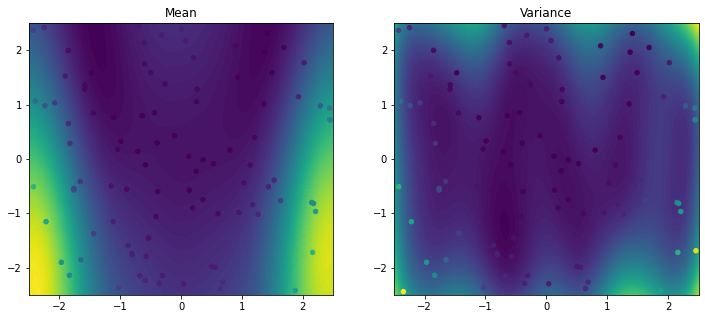

In [71]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_title('Mean')
axs[1].set_title('Variance')
axs[0].contourf(X1,X2,mean_grid,100)
axs[1].contourf(X1,X2,var_grid,100)
axs[0].scatter(X[:,0],X[:,1],c=Y,s=20)
axs[1].scatter(X[:,0],X[:,1],c=Y,s=20)
plt.show()

If we wanted to optimize the **mean** of this GP, we need an objective function, which I will define as follows:

In [72]:
def gp_obj(x,m):
	mean,var = m.predict(np.array([x]))
	mean = mean.item()
	var = var.item()
	return mean

To optimize I will use ```scipy.minimize```

In [73]:
x0 = [0,0]
res = minimize(gp_obj,x0,args=(m))
x_opt = res.x 
f_opt = res.fun
print('optimal x: ',x_opt)
print('optimal f(x): ',f_opt)

optimal x:  [1.501762   3.23411087]
optimal f(x):  -110.81004643887711


Your task, is to optimize the Rosenbrock function using as few function evaluations as possible using Bayesian optimisation. 
You will need to think about creating an initial Gaussian process, optimizing some objective (you may have to change the above ```gp_obj``` function), and iterating the proceedure. 

E.g. 
1. Sample points in bounds 
2. Create GP
3. Optimize some aquisition function 
4. Sample function 
5. Repeat from 2